# Backtesting 
- A single path of a stochastic process.
- Doesn’t explain the financial discovery!
- Doesn’t allow us to forecast performance and risks!!

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime as dt
import math

import vectorbt as vbt

## 0. Data loading

Lets try to predict USD/RUB with its lags and rates dynamics

In [38]:
usd_rub = vbt.YFData.download(
    'RUB=X',
    missing_index='drop'
).get('Close')

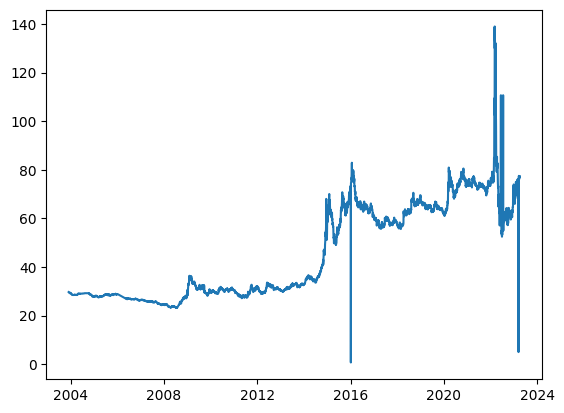

In [39]:
plt.plot(usd_rub)

In [40]:
usd_rub[usd_rub<10] = np.nan

In [41]:
usd_rub = usd_rub.fillna(method='ffill')
usd_rub.describe()

count    4908.000000
mean       45.917613
std        19.269468
min        23.170000
25%        29.010000
50%        33.394199
75%        64.091227
max       138.965103
Name: Close, dtype: float64

In [42]:
# reading historical rates

us_rates = pd.read_csv(
    r'United States 1-Year Bond Yield Historical Data.csv', index_col=0, usecols=['Date', 'Price'], parse_dates=['Date']
).rename(columns={'Price':'Close'})

rus_rates = pd.read_csv(
    r'Russia 1-Year Bond Yield Historical Data.csv', index_col=0, usecols=['Date', 'Price'], parse_dates=['Date']
).rename(columns={'Price':'Close'})

rates = pd.merge(us_rates, rus_rates, how='outer', left_index=True, right_index=True, suffixes=('_us_rate', '_rus_rate'))

<Axes: xlabel='Date'>

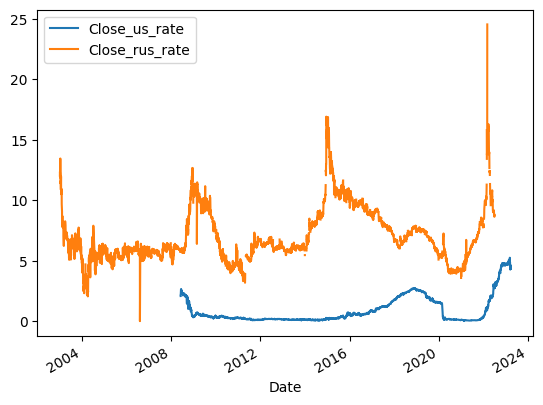

In [43]:
rates[['Close_us_rate', 'Close_rus_rate']].plot()

In [44]:
usd_rub = usd_rub.tz_localize(None)
data = pd.merge(usd_rub, rates, how='left', left_index=True, right_index=True)
data.head()

,Close,Close_us_rate,Close_rus_rate
Date,,,
2003-12-01,29.700001,NaN,NaN
2003-12-02,29.690001,NaN,NaN
2003-12-03,29.690001,NaN,NaN
2003-12-04,29.680000,NaN,NaN
2003-12-05,29.620001,NaN,6.049


In [45]:
data.fillna(method='ffill', inplace=True)

In [46]:
data.head()

,Close,Close_us_rate,Close_rus_rate
Date,,,
2003-12-01,29.700001,NaN,NaN
2003-12-02,29.690001,NaN,NaN
2003-12-03,29.690001,NaN,NaN
2003-12-04,29.680000,NaN,NaN
2003-12-05,29.620001,NaN,6.049


## 1. Data preparation and labeling

Triple-barrier method labels an observation according to the first barrier touched out of three barriers.

![title](3bar.png)

In [47]:
def applyPtSlOnT1(close,events,ptSl):
    '''
    close: A pandas series of prices.
    events: A pandas dataframe, with columns,
        -t1: The timestamp of vertical barrier. When the value is np.nan, there will not be a vertical barrier.
        - trgt: The unit width of the horizontal barriers.
    ptSl: A list of two non-negative float values:
        - ptSl[0]: The factor that multiplies trgt to set the width of the upper barrier.
          If 0, there will not be an upper barrier.
        - ptSl[1]: The factor that multiplies trgt to set the width of the lower barrier.
          If 0, there will not be a lower barrier.
    '''
    # apply stop loss/profit taking, if it takes place before t1 (end of event)
    out=events[['t1']].copy(deep=True)
    if ptSl[0]>0:pt=ptSl[0]*events['trgt']
    else:pt=pd.Series(index=events.index) # NaNs
    if ptSl[1]>0:sl=-ptSl[1]*events['trgt']
    else:sl=pd.Series(index=events.index) # NaNs
    for loc,t1 in events['t1'].fillna(close.index[-1]).items():
        df0=close[loc:t1] # path prices
        df0=(df0/close[loc]-1) #*events.at[loc,'side'] # path returns
        out.loc[loc,'sl']=df0[df0<sl[loc]].index.min() # earliest stop loss.
        out.loc[loc,'pt']=df0[df0>pt[loc]].index.min() # earliest profit taking.
    return out

In [48]:
close = data.Close
events = pd.DataFrame({
    't1': close.index + dt.timedelta(days=10), # vertical barrier = 10 days
    'trgt': close.pct_change().rolling(50).std() # horisontal barriers are rolling std dev
})
ptSl = [1, 0.5] # vertical barrier is 2x higher

In [49]:
out = applyPtSlOnT1(close, events, ptSl)
out.tail()

,t1,sl,pt
Date,,,
2023-03-27 23:00:00,2023-04-06 23:00:00,NaT,NaT
2023-03-28 23:00:00,2023-04-07 23:00:00,NaT,NaT
2023-03-29 23:00:00,2023-04-08 23:00:00,NaT,NaT
2023-03-30 23:00:00,2023-04-09 23:00:00,NaT,NaT
2023-03-31 23:00:00,2023-04-10 23:00:00,NaT,NaT


In [50]:
target = out.apply(
    lambda x: 1 if x.idxmin() == 'pt' else -1 if x.idxmin() == 'sl' else 0,
    axis=1
)

In [51]:
# create a data transformer 

from sklearn.base import BaseEstimator, TransformerMixin

class VerticalToHorizontal(BaseEstimator, TransformerMixin):
    '''
    Data transformer, converting time series DataFrame from vertical to horizontal format. 
    
    Input - DataFrame, columns: variable type [OHLCV, regressors], rows: observation date
    Output - DataFrame, columns: lags of selected variables (OHLCV), rows: date of observation
    '''
    
    def fit(self, X, y=None,  lag_start=1, lag_end=9, features=['Adj Close', 'Volume']):
        self.lag_start = lag_start
        self.lag_end = lag_end
        self.features = features
        return self

    def transform(self, X, y=None):

        Xt = X[self.features].copy()
        X_out = pd.DataFrame(index=Xt.index)

        # add lags of the original time series as features
        for feature in self.features:
            for i in range(self.lag_start, self.lag_end):
                X_out["{}_lag_{}".format(feature, i)] = Xt[feature].shift(i)

        return X_out

In [52]:
data.head()

,Close,Close_us_rate,Close_rus_rate
Date,,,
2003-12-01,29.700001,NaN,NaN
2003-12-02,29.690001,NaN,NaN
2003-12-03,29.690001,NaN,NaN
2003-12-04,29.680000,NaN,NaN
2003-12-05,29.620001,NaN,6.049


In [53]:
data_x = data.copy()
data_x.Close = data_x.Close.pct_change()

X = VerticalToHorizontal().fit_transform(data_x, features=data_x.columns)

In [54]:
X.tail()

,Close_lag_1,Close_lag_2,Close_lag_3,Close_lag_4,Close_lag_5,Close_lag_6,Close_lag_7,Close_lag_8,Close_us_rate_lag_1,Close_us_rate_lag_2,...,Close_us_rate_lag_7,Close_us_rate_lag_8,Close_rus_rate_lag_1,Close_rus_rate_lag_2,Close_rus_rate_lag_3,Close_rus_rate_lag_4,Close_rus_rate_lag_5,Close_rus_rate_lag_6,Close_rus_rate_lag_7,Close_rus_rate_lag_8
Date,,,,,,,,,,,,,,,,,,,,,
2023-03-27 23:00:00,0.016850,-0.012030,-0.004209,-0.003227,0.007020,0.006016,0.009906,0.000000,4.3146,4.3146,...,4.306,4.493,15.77,15.77,15.77,15.77,15.77,15.77,15.77,15.77
2023-03-28 23:00:00,-0.009645,0.016850,-0.012030,-0.004209,-0.003227,0.007020,0.006016,0.009906,4.3146,4.3146,...,4.386,4.306,15.77,15.77,15.77,15.77,15.77,15.77,15.77,15.77
2023-03-29 23:00:00,0.000327,-0.009645,0.016850,-0.012030,-0.004209,-0.003227,0.007020,0.006016,4.3146,4.3146,...,4.631,4.386,15.77,15.77,15.77,15.77,15.77,15.77,15.77,15.77
2023-03-30 23:00:00,0.009997,0.000327,-0.009645,0.016850,-0.012030,-0.004209,-0.003227,0.007020,4.3146,4.3146,...,4.514,4.631,15.77,15.77,15.77,15.77,15.77,15.77,15.77,15.77
2023-03-31 23:00:00,-0.000647,0.009997,0.000327,-0.009645,0.016850,-0.012030,-0.004209,-0.003227,4.3146,4.3146,...,4.375,4.514,15.77,15.77,15.77,15.77,15.77,15.77,15.77,15.77


In [55]:
y = target+1
y = y[X.index]

## 2. Model selection

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import label_binarize
from xgboost import XGBClassifier

from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.preprocessing import label_binarize
import warnings
warnings.filterwarnings("ignore")

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, train_size=0.7)

In [58]:
# handling with possible imbalanced data
classes_weights = class_weight.compute_sample_weight(
    'balanced', y_train
)

model = XGBClassifier(
        objective='multi:softmax'
    )

In [59]:
res = model.fit(X_train, y_train, sample_weight=classes_weights)

## 3. Model evaluation

In [60]:
best_model = res

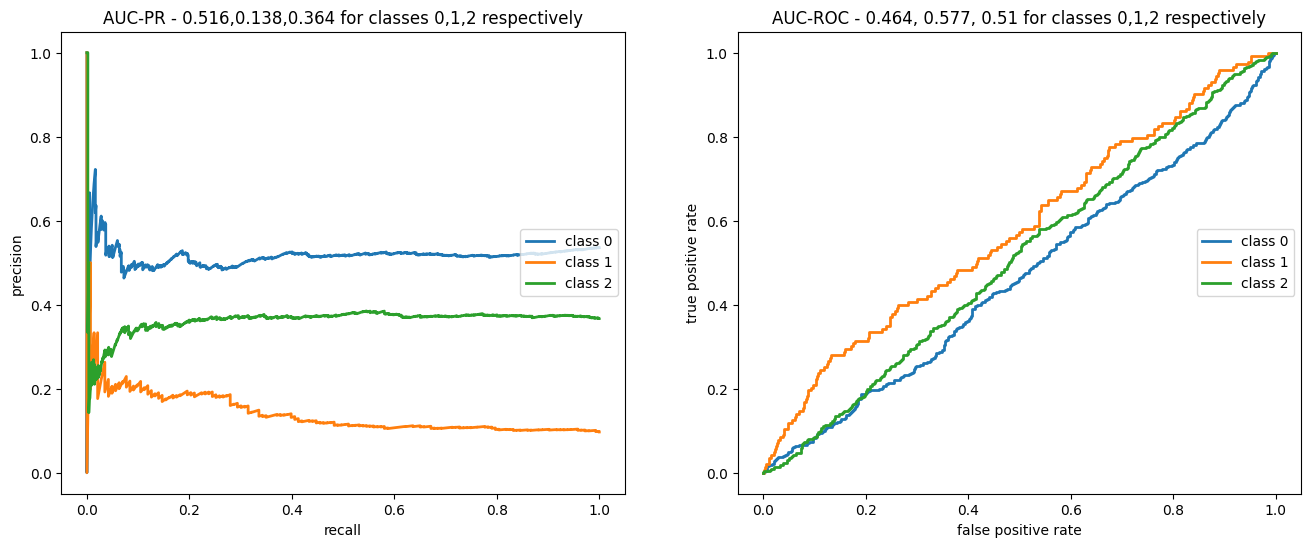

In [61]:
y_pred = best_model.predict_proba(X_test)
y_test_bin = label_binarize(y_test, classes=res.classes_)

precision = dict()
recall = dict()
fpr = dict()
tpr = dict()

fig, axes = plt.subplots(1, 2, figsize=(16,6))

for i, class_ in enumerate(res.classes_):
    precision[class_], recall[class_], _ = precision_recall_curve(y_test_bin[:, i],
                                                        y_pred[:, i])
    fpr[class_], tpr[class_], _ = roc_curve(y_test_bin[:, i],
                                                        y_pred[:, i])

    axes[0].plot(recall[class_], precision[class_], lw=2, label='class {}'.format(class_))
    axes[1].plot(fpr[class_], tpr[class_], lw=2, label='class {}'.format(class_))


axes[0].set_title(f'''AUC-PR - {
    ','.join([str(round(auc(recall[i], precision[i]), 3)) for i in recall])
} for classes {
    ','.join([str(i) for i in res.classes_])
} respectively''')

axes[0].set_xlabel('recall')
axes[0].set_ylabel('precision')
axes[0].legend(loc='right')

axes[1].set_title(f'''AUC-ROC - {
    ', '.join([str(round(auc(fpr[i], tpr[i]), 3)) for i in fpr])
} for classes {
    ','.join([str(i) for i in res.classes_])
} respectively''')

axes[1].set_xlabel('false positive rate')
axes[1].set_ylabel('true positive rate')
axes[1].legend(loc='right')

### 3.1 Probability threshold.

In [62]:
# it is necessary to choose the optimal level of probability cutoffs
# it is better to choose it on validation set
# we'll choose it based on maximization of F_beta_score
# beta should be big: due to low event rate, we want more recall than precision
# let's say beta = 10

y_train_bin = label_binarize(y_train, classes=best_model.classes_)

preds_pos = best_model.predict_proba(X_train)[:,2]
preds_neg = best_model.predict_proba(X_train)[:,0]

precision_pos, recall_pos, thresholds_pos = precision_recall_curve(y_train_bin[:,2], preds_pos)
precision_neg, recall_neg, thresholds_neg = precision_recall_curve(y_train_bin[:,0], preds_neg)


beta_score = lambda precision, recall, beta=10: (1+beta**2)*(precision * recall)/(beta**2 * precision + recall)

betas_pos = beta_score(precision_pos, recall_pos)
betas_neg = beta_score(precision_neg, recall_neg)

opt_t_pos = thresholds_pos[np.argmax(betas_pos)]
opt_t_neg = thresholds_neg[np.argmax(betas_neg)]

print('Optimal threshold for positive jumps - {:.3f}, for negative jumps - {:.3f}'.format(opt_t_pos, opt_t_neg))

Optimal threshold for positive jumps - 0.361, for negative jumps - 0.319


In [63]:
tr_rule1_probs = best_model.predict_proba(X_test)
tr_rule1_signal = -(tr_rule1_probs[:,0] > opt_t_neg).astype(int)  + (tr_rule1_probs[:,2] > opt_t_pos).astype(int)

In [64]:
signals_buy = tr_rule1_signal == 1
signals_sell = tr_rule1_signal == -1

## 4. Backtesting

- One disadvantage of the walk-forward method is that it can be easily overfit.
- The reason is that without random sampling, there is a single path of testing that can be repeated over and over until a false positive appears.
- That's why we need to keep information about all the backtests we've done, so we can make adjustments for it later

In [251]:
from copy import deepcopy

class pf_log(vbt.Portfolio):
    '''
    Redefine the standard VectorBT portfolio creation methods
    so that the information about the backtesting results will be saved
    on the class level
    '''

    __backtest_tries = {}

    @classmethod
    def __add_bt(cls, pf):
        if all([not pf.value().equals(cls.__backtest_tries[i]) for i in cls.__backtest_tries]):
            cls.__backtest_tries[len(cls.__backtest_tries)] = deepcopy(pf.value())

    @classmethod
    def get_bt_tries(cls):
        return pd.DataFrame(cls.__backtest_tries)

    @classmethod
    def from_signals(cls, *args, **kwargs):
        pf = super().from_signals(*args, **kwargs)
        cls.__add_bt(pf)
        return pf
    
    @classmethod
    def from_orders(cls, *args, **kwargs):
        pf = super().orders(*args, **kwargs)
        cls.__add_bt(pf)
        return pf

    @classmethod
    def from_order_func(cls, *args, **kwargs):
        pf = super().from_order_func(*args, **kwargs)
        cls.__add_bt(pf)
        return pf

### 4.1 Walk-forward backtesting

In [252]:
pf = pf_log.from_signals(
    close = close.loc[X_test.index],
    entries = signals_buy,
    exits = signals_sell,
    freq='1d')

In [253]:
pf.get_bt_tries()

,0
Date,
2017-08-07 23:00:00,100.000000
2017-08-08 23:00:00,100.000000
2017-08-09 23:00:00,100.000000
2017-08-10 23:00:00,100.000000
2017-08-13 23:00:00,99.666606
...,...
2023-03-27 23:00:00,119.657040
2023-03-28 23:00:00,119.657040
2023-03-29 23:00:00,119.657040


In [254]:
pf.stats()

Start                               2017-08-07 23:00:00
End                                 2023-03-31 23:00:00
Period                               1473 days 00:00:00
Start Value                                       100.0
End Value                                     119.65704
Total Return [%]                               19.65704
Benchmark Return [%]                          29.137881
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                              18.818238
Max Drawdown Duration                 742 days 00:00:00
Total Trades                                         72
Total Closed Trades                                  72
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  48.611111
Best Trade [%]                                28.129502
Worst Trade [%]                               -8

#### 4.1.1. Calculate probability of backtesting overfitting (PBO)

1. Form a matrix $M$ by collecting the performance series from the $N$ trials.
-  Each column $n = 1, … , N$ represents a vector of PnL (mark-to-market profits and losses) over $t = 1, … , T$ observations associated with a particular model configuration

2. Partition $M$ across rows, into an even number $S$ of disjoint submatrices of equal dimensions. Each of these submatrices $M_s$ , with $s = 1, … , S$, is of order $(\frac{T}{S} N)$.

3. Form all combinations $C_s$ of $M_s$ , taken in groups of size $\frac{S}{2}$ . This gives a total number of $C^{S/2}_{S}$ combinations

4. For each combination $c \in C_s$ we

    1. Form the training set $J$, by joining the $S∕2$ submatrices $M_s$ that constitute $c$. $J$ is a matrix of order $\frac{T}{S} \frac{S}{2} * N = \frac{T}{2} * N$.

    2. Form the testing set $\overline{J}$, as the complement of $J$ in $M$. In other words, $\overline{J}$ is the $\frac{T}{2} * N$ matrix formed by all rows of $M$ that are not part of $J$.

    3. Form a vector $R$ of performance statistics of order $N$, where the $n$-th item of $R$ reports the performance associated with the $n$-th column of $J$ (the training set).

    4. Determine the element $n∗$ such that $R_n ≤ R_n∗ , ∀n = 1, … , N$. In other words, $n∗ = arg \max_n {R_n }$.

    5. Form a vector $\overline{R}$ of performance statistics of order $N$, where the $n$-th item of $\overline{R}$ reports the performance associated with the $n$-th column of $J$ (the testing set). 
        
    6. Determine the relative rank of $\overline{R_{n∗}}$ within $\overline{R}$, We denote this relative rank as $\overline{\omega_c}$, where $\overline{\omega_c} \in (0,1)$. This is the relative rank of the out-of-sample (OOS) performance associated with the trial chosen in-sample (IS). If the strategy optimization procedure does not overfit, we should observe that $\overline{R_{n*}}$ systematically outperforms $\overline{R}$ (OOS), just as $R_{n∗}$ outperformed $R$ (IS).
        
    7. Define the logit $\lambda_c = \log{\frac{\overline{\omega_c}}{1 - \overline{\omega_c}}} $. This presents the property that $\lambda_c = 0$ when $\overline{R_{n∗}}$ coincides with the median of $\overline{R}$. High logit values imply a consistency between IS and OOS performance, which indicates a low level of backtest overfitting.

5. Compute the distribution of ranks OOS by collecting all the $\lambda_c$, for $c ∈ CS$. The probability distribution function $f (\lambda)$ is then estimated as the relative frequency at which $\lambda$ occurred across all $C_s$ with $\int^{\infty}_{-\infty} f (\lambda) d\lambda$. Finally, the PBO is estimated as $PBO = \int^{0}_{-\infty} f (\lambda) d\lambda$ as that is the probability associated with IS optimal strategies that underperform OOS.

In [255]:
import pypbo as pbo

Convert from DataFrame to numpy array.
Total sample size: 1,472, chunck size: 92
No. of Chuncks: 16
No. of combinations = 12,870


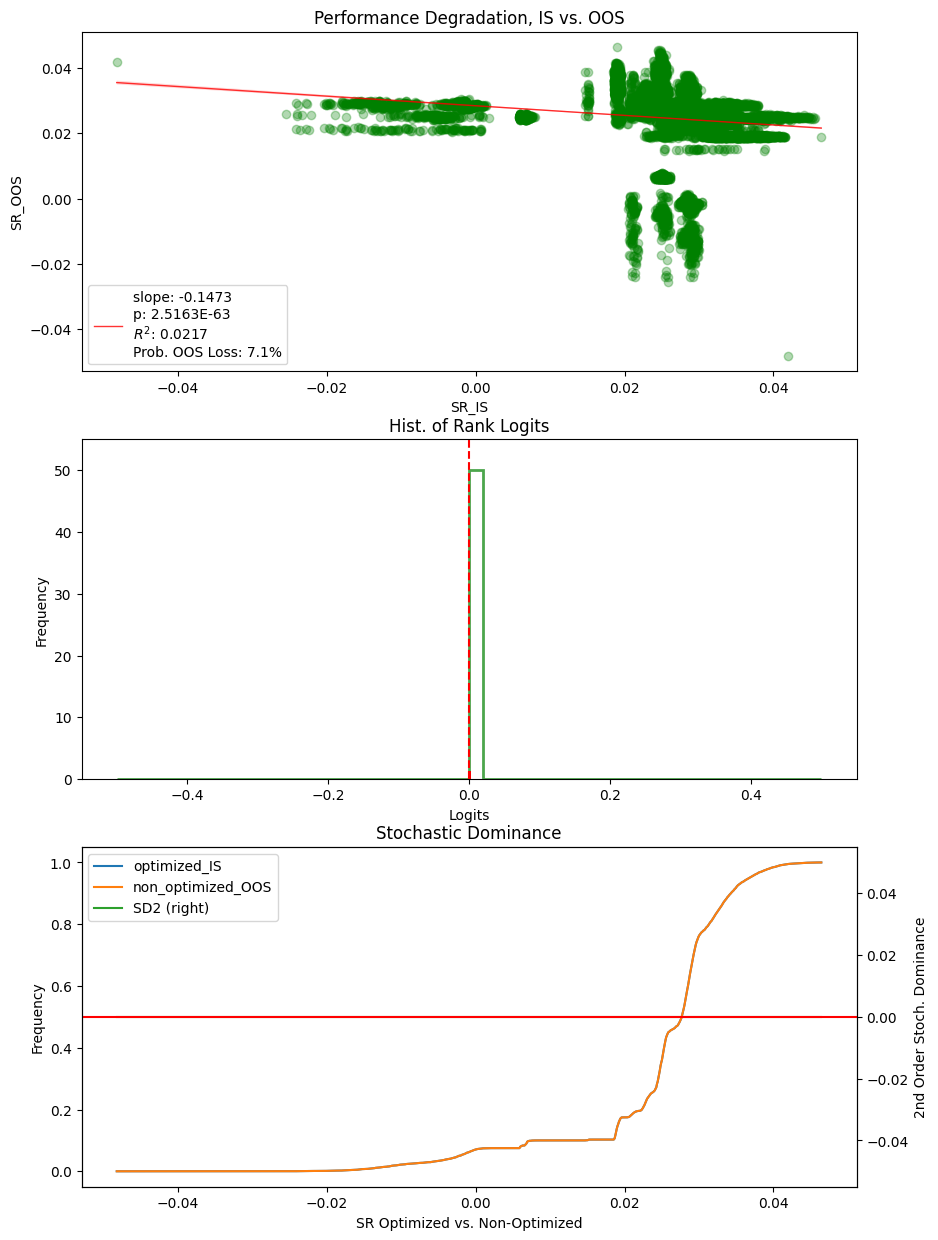

In [256]:
pbo_ = pbo.pbo(
    pf.get_bt_tries(),
    S = 16,
    metric_func=lambda x: pd.DataFrame(x).pct_change().mean()/pd.DataFrame(x).pct_change().std(),
    threshold=0,
    verbose=True,
    plot=True,
    hist=True
)

In [257]:
test_pbo, *args = pbo_

In [258]:
test_pbo

1.0

#### 4.1.2. Cross-validation in Finance

In [ ]:
from sklearn.model_selection._split import _BaseKFold
from sklearn.model_selection import RandomizedSearchCV
from itertools import combinations
from functools import reduce

One reason k-fold CV fails in finance is because observations cannot be assumed to be drawn from an IID process.
- Because labels are derived from overlapping datapoints, $Y_t ≈ Y_{t+1}$.
- Because of the serial correlation, $X_t ≈ X_{t+1}$.

Solution: Drop from the training set any observation $i$ where $Y_i$ is a function of information used to determine $Y_j$ , and $j$ belongs to the testing set.
- For example, $Y_i$ and $Y_j$ should not span overlapping periods.
- Since financial features often incorporate series that exhibit serial correlation (like ARMA processes), we should eliminate from the training set observations that immediately follow an observation in the testing set.

![title](purgedkfold.png)

In [ ]:
class PurgedKFold(_BaseKFold):
    '''
    Extend KFold class to work with labels that span intervals
    The train is purged of observations overlapping test-label intervals
    Test set is assumed contiguous (shuffle=False), w/o training samples in between
    '''
    def __init__(self,n_splits=5,t1=None,pctEmbargo=0.01):
        if not isinstance(t1,pd.Series):
            raise ValueError('Label Through Dates must be a pd.Series')
        super(PurgedKFold,self).__init__(n_splits,shuffle=False,random_state=None)
        self.t1=t1
        self.pctEmbargo=pctEmbargo

    def split(self,X,y=None,groups=None):
        if (X.index==self.t1.index).sum()!=len(self.t1):
            raise ValueError('X and ThruDateValues must have the same index')
        indices=np.arange(X.shape[0])
        mbrg=int(X.shape[0]*self.pctEmbargo)
        test_starts=[(i[0],i[-1]+1) for i in \
            np.array_split(np.arange(X.shape[0]),self.n_splits)]
        for i,j in test_starts:
            t0=self.t1.index[i] # start of test set
            test_indices=indices[i:j]
            maxT1Idx=self.t1.index.searchsorted(self.t1[test_indices].max())
            train_indices=self.t1.index.searchsorted(self.t1[self.t1<=t0].index)
            if maxT1Idx<X.shape[0]: # right train (with embargo)
                train_indices=np.concatenate((train_indices,indices[maxT1Idx+mbrg:]))
            yield train_indices,test_indices

### 4.2 The Combinatorial Purged Cross-Validation Method

#### Combinatorial Splits

Consider $T$ observations partitioned into $N$ groups without shuffling, where groups $n = 1, … , N − 1$ are of size $T∕N$, the $N$-th group is of size $T − ⌊T∕N⌋ (N − 1)$, and $⌊.⌋$ is the floor or integer function. For a testing set of size $k$ groups, the number of possible training/testing splits is $C^{N-k}_N$


Since each combination involves $k$ tested groups, the total number of tested groups is $k C^{N-k}_N$. And since we have computed all possible combinations, these tested groups are uniformly distributed across all $N$ (each group belongs to the same number of training and testing sets). The implication is that from $k$-sized testing sets on $N$ groups we can backtest a total number of paths $\phi [N, k] = \frac{k}{N} C^{N-k}_N$,

Picture illustrates the composition of train/test splits for N = 6 and k = 2.

![title](cpcv1.png)

#### CPCV backtesting algorithm

1. Partition $T$ observations into $N$ groups without shuffling, where groups $n = 1, … , N − 1$ are of size $⌊T∕N⌋$, and the $N$-th group is of size $T$ −
⌊T∕N⌋ (N − 1).
2. Compute all possible training/testing splits, where for each split $N − k$ groups constitute the training set and $k$ groups constitute the testing set.
3. For any pair of labels $(y_i , y_j)$, where $y_i$ belongs to the training set and $y_j$ belongs to the testing set, apply the PurgedKFold class to purge $y_i$ if $y_i$ spans over a period used to determine label $y_j$ . 
4. Fit classifiers on the $C^{N-k}_N$ training sets, and produce forecasts on the respective $C^{k}_N$ testing sets.
5. Compute the $\phi [N, k]$ backtest paths. You can calculate one Sharpe ratio from each path, and from that derive the empirical distribution of the strategy’s Sharpe ratio.

Picture shows the assignment of each tested group to one backtest path. For example, path 1 is the result of combining the forecasts from (G1, S1), (G2, S1), (G3, S2), (G4, S3), (G5, S4) and (G6, S5).

![title](cpcv2.png)

In [261]:
class CPCV(_BaseKFold):
    '''
    Combinatorial purged cross-validation
    '''

    def __init__(self, X, N=6, k=2):
        self.X = X
        self.N = N
        self.k = k

        
    def split(self):
        # removing first m items from time series

        split_ids = np.linspace(0, len(self.X), self.N+1).astype(int)
        split_ids = [np.arange(split_ids[i], split_ids[i+1]).tolist() for i in range(split_ids.size-1)]
        split_ids = dict(zip(range(len(split_ids)), split_ids))
        
        test_ids = tuple(combinations(split_ids, r=self.k))
        func = lambda x: tuple((i for i in split_ids if i not in x))
        train_ids = tuple([func(i) for i in test_ids])

        ids = zip(test_ids, train_ids)

        for test, train in ids:

            test_index = reduce(lambda x, y: x+y, [split_ids[i] for i in test])
            train_index = reduce(lambda x, y: x+y, [split_ids[i] for i in train])
            
            yield (train_index, test_index)

In [262]:
N, k = 6, 2
combs = int((reduce(lambda x,y: (N-x)*y, range(k)) / math.factorial(k-1) - 1) * N / k)

signals_buy_nans = pd.DataFrame(index=X.index, columns=range(combs))
signals_sell_nans = pd.DataFrame(index=X.index, columns=range(combs))


param_dist = {
    'n_estimators': range(200, 1000, 200),
    'learning_rate': np.linspace(0.01, 0.6, 5),
    'subsample': np.linspace(0.3, 0.9, 3),
    'max_depth': range(3, 9),
    'colsample_bytree': np.linspace(0.5, 0.9, 5),
    'min_child_weight': range(1, 4)         
}

estimator = XGBClassifier(
        objective='multi:softmax'
    )


# X.fillna(0, inplace=True) # bad move

In [263]:
for i, (train_ids, test_ids) in enumerate(CPCV(X, N, k).split()):
    X_train, y_train = X.iloc[train_ids, :], y.iloc[train_ids]
    X_test, y_test = X.iloc[test_ids, :], y.iloc[test_ids]
    t = out.t1.loc[X_train.index]
    
    model = RandomizedSearchCV(estimator, param_dist, cv = PurgedKFold(t1=t).split(X_train))
    res = model.fit(X_train, y_train).best_estimator_
    
    pred_pos = res.predict_proba(X_test)[:,2]
    pred_neg = res.predict_proba(X_test)[:,0]

    signals_buy_nans.iloc[test_ids, i] = pred_pos
    signals_sell_nans.iloc[test_ids, i] = pred_neg

In [264]:
phi = int(combs * k / N)

signals_buy = pd.DataFrame(index=signals_buy_nans.index, columns=range(phi))
signals_sell = pd.DataFrame(index=signals_sell_nans.index, columns=range(phi))

for date_, series in signals_buy_nans.iterrows():
    signals_buy.loc[date_, :] = series.dropna().values

for date_, series in signals_sell_nans.iterrows():
    signals_sell.loc[date_, :] = series.dropna().values

In [265]:
signals_buy = signals_buy.applymap(lambda x: 1 if x>opt_t_pos else 0)
signals_sell = signals_sell.applymap(lambda x: 1 if x>opt_t_neg else 0)

In [266]:
pf_cpcv = vbt.Portfolio.from_signals(
    close = np.tile(close.loc[signals_buy.index], (signals_buy.shape[1], 1)).T,
    entries = signals_buy,
    exits = signals_sell,
    freq='1d')

Text(0.5, 1.0, 'Alternative backtesting paths')

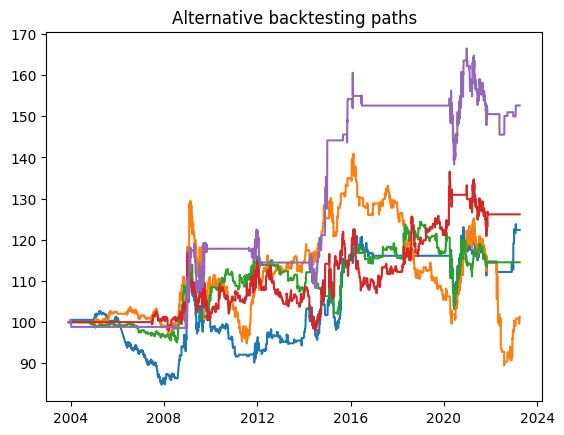

In [267]:
plt.plot(pf_cpcv.value())
plt.title('Alternative backtesting paths')

In [268]:
pf_cpcv.sharpe_ratio()

0    0.211346
1    0.059969
2    0.189510
3    0.238816
4    0.409596
Name: sharpe_ratio, dtype: float64

In [269]:
pf_cpcv.sharpe_ratio().mean()

0.22184719775382114

### 4.3 Synthetic Data Backtesting

- The idea is to simulate a random process whose trajectory is the dynamics of our asset
- The chosen form of the stochastic process must reflect the specifics of the instrument

Let's suppose a discrete Ornstein-Uhlenbeck (O-U) process on prices


$$
SDE: dS_t = \lambda (\mu - S_t)dt + \sigma dW_t
$$

$$
Solution: P_{i+1} = P_i e^{-\lambda \delta} + \mu (1-e^{-\lambda \delta}) + \sigma \sqrt{\frac{1-e^{-2\lambda \delta}}{2 \lambda}} N_{0,1}
$$

https://www.statisticshowto.com/wp-content/uploads/2016/01/Calibrating-the-Ornstein.pdf

In [65]:
import math
from statsmodels.api import add_constant, OLS
from scipy.stats import norm, skew, kurtosis

In [97]:
# fitting parameters
def fit_OU(close, delta=1):
    ols = OLS(close[1:], add_constant(close.shift(1)[1:])).fit()
    a, b = ols.params
    sde = math.sqrt(ols.scale)
    lambda_ = -math.log(b)/delta
    myu = a/(1-b)
    sigma = sde * math.sqrt(-2 * math.log(b) / (delta * (1-b ** 2)))
    return lambda_, myu, sigma



np.random.seed(777)
# simulating with fitted params
def simulate_OU(close, delta=1, num_iter=10, N=None, lambda_=None, myu=None, sigma=None):
    if not N: N = len(close)
    if not lambda_: lambda_, myu, sigma = fit_OU(close, delta)
    _X_0 = close[0]
    paths = np.tile(_X_0, num_iter)

    # sorry for loops!
    for i in range(N-1):
        paths = np.vstack((paths, (paths[i] * np.exp(-lambda_ * delta) + myu * (1-np.exp(-lambda_ * delta)) + sigma * np.sqrt((1-np.exp(-2*lambda_*delta))/(2*lambda_)) * np.random.normal(size=num_iter))))

    return paths

In [98]:
lambda_, myu, sigma = fit_OU(close)
paths = simulate_OU(close.loc[X_test.index], lambda_=lambda_, myu=myu, sigma=sigma)
paths = pd.DataFrame(paths, index=X_test.index)

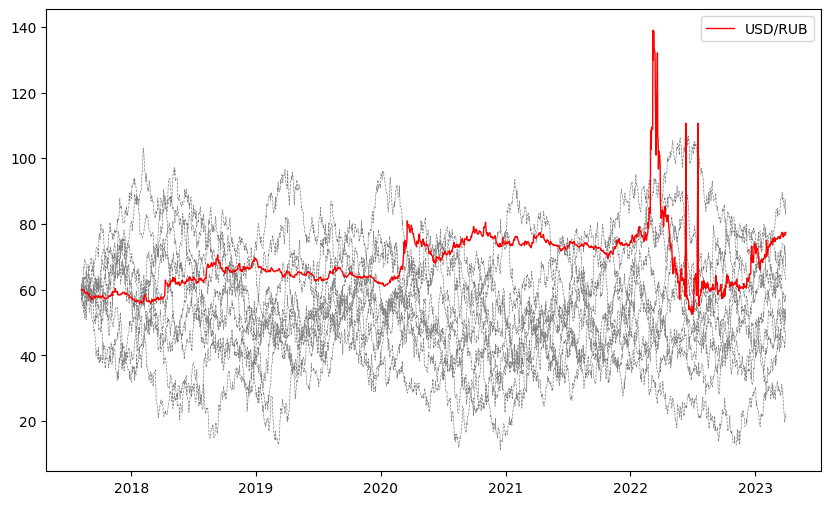

In [99]:
plt.figure(figsize=(10,6))
plt.plot(paths.loc[X_test.index,:], color = 'grey', ls = '--', lw=0.5)
plt.plot(close.loc[X_test.index], color='r', lw = 1, label = 'USD/RUB')
# plt.plot(pf.value()*close.loc[X_test.index]/100, color='b', lw=1, label='Strategy')
plt.legend()
plt.show()

In [93]:
def sharpe(strategy, rf=0.0, periods=365):
    strategy = pd.DataFrame(strategy)
    pf_rets = strategy.pct_change() - rf/periods
    return pf_rets.mean()/pf_rets.std() * math.sqrt(periods)


def prob_sharpe(strategy, sr_tested, sr_etalon=0):
    '''
    The probabilistic Sharpe ratio (PSR) provides an adjusted estimate of SR, by removing
    the inflationary effect caused by short series with skewed and/or fat-tailed returns.

    Given a user-defined benchmark Sharpe ratio (sr_etalon) and an observed Sharpe ratio SR (sr_tested) estimates the probability that sr_tested is greater than sr_etalon

    It should exceed 0.95, for the standard significance level of 5%
    '''
    strategy = pd.DataFrame(strategy)
    y3 = skew(strategy.pct_change()[1:])
    y4 = kurtosis(strategy.pct_change()[1:]) + 3
    stat = (sr_tested - sr_etalon) * math.sqrt(len(strategy)-1) / math.sqrt(1-y3 * sr_tested + (y4-1) * sr_tested / 4)
    return norm.cdf(stat)


def deflated_sharpe(strategy, bagging_strategies, sr_tested):
    '''
    The deflated Sharpe ratio (DSR) is a PSR where the rejection threshold is adjusted to
    reflect the multiplicity of trials.

    Corrects SR for inflationary effects caused by non-Normal returns, track record length, and multiple testing/selection bias.

    It should exceed 0.95, for the standard significance level of 5%
    '''
    y = round( (1.-math.gamma(1+1.e-8))*1.e14 )*1.e-6   # Euler-Mascheroni constant
    sharpes = sharpe(bagging_strategies)
    N = bagging_strategies.shape[1]
    sr_std = sharpes.std()
    sr_etalon = sr_std * ((1-y) / norm.cdf(1-1/N) + y / norm.cdf(1-1/(N * math.e)))
    return prob_sharpe(strategy, sr_tested, sr_etalon)

In [94]:
signals_buy_synt = np.zeros_like(X_test.index, dtype=int)
signals_sell_synt = np.zeros_like(X_test.index, dtype=int)

for iter_ in paths:
    data_x_s = data_x.copy().loc[X_test.index]
    data_x_s.Close = paths[iter_]
    data_x_s.Close = data_x_s.Close.pct_change()
    X_test_synt = VerticalToHorizontal().fit_transform(data_x_s, features=data_x_s.columns).fillna(0)
    
    tr_rule1_probs = best_model.predict_proba(X_test_synt)
    tr_rule1_signal = -(tr_rule1_probs[:,0] > opt_t_neg).astype(int)  + (tr_rule1_probs[:,2] > opt_t_pos).astype(int)
    signals_buy = tr_rule1_signal == 1
    signals_sell = tr_rule1_signal == -1

    signals_buy_synt = np.vstack((signals_buy_synt, signals_buy))
    signals_sell_synt = np.vstack((signals_sell_synt, signals_sell))

signals_buy_synt = signals_buy_synt[1:,:]
signals_sell_synt = signals_sell_synt[1:,:]

In [95]:
pf_synt = vbt.Portfolio.from_signals(
    close = paths,
    entries = signals_buy_synt.T,
    exits = signals_sell_synt.T,
    freq='1d')

In [96]:
pf_synt.stats(
    agg_func=np.mean
).T

Start                               2017-08-07 23:00:00
End                                 2023-03-31 23:00:00
Period                               1473 days 00:00:00
Start Value                                       100.0
End Value                                    118.835061
Total Return [%]                              18.835061
Benchmark Return [%]                          -6.246774
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                              57.913218
Max Drawdown Duration                 784 days 16:48:00
Total Trades                                      131.6
Total Closed Trades                               131.5
Total Open Trades                                   0.1
Open Trade PnL                                      0.0
Win Rate [%]                                  49.514259
Best Trade [%]                                54.602603
Worst Trade [%]                              -24

In [316]:
prob_sharpe(pf.value(), pf.sharpe_ratio())

0.9697889560488222

In [317]:
deflated_sharpe(pf.value(), pf_synt.value(), pf.sharpe_ratio())

0.279613885752385

## Further Reading:

- [Synthetic Data & Stress-scenario basics](https://towardsdatascience.com/ai-in-finance-how-to-finally-start-to-believe-your-backtests-2-3-adfd13da20ec)

- [Synthetic Data Generation advanced methodology](https://arxiv.org/abs/2007.04838)

- [Seven Sins of Quantitative Investing by Deutsche Bank](https://newyork.qwafafew.org/wp-content/uploads/sites/4/2015/10/Luo_20150128.pdf)